In [2]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm
import time
import gcmpyo3

from core.amp.likelihood import probit_likelihood
from core.amp.prior.nonseparable_gaussian_prior import NonSepGaussianPrior
import core.erm.logistic_regression as logistic_regression
from core.utility import KERNEL_COEFICIENTS, get_additional_noise_from_kappas, LOGISTIC_APPROX_COEF, sigmoid, build_gcm_from_activation, omega_inv_hessian_trace_random_features

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
d         = 200
seeds     = 30

n_over_d  = 2.0 
n         = int(d * n_over_d)
# ratio num of samples / dimension of teacher
noise_std = 0.5
noise_var = noise_std**2

activation= 'erf'
_, kappa1, kappastar = KERNEL_COEFICIENTS[activation]

In [3]:
# inv_alpha_range = np.linspace(0.5, 4.5, n_alpha)

inv_alpha_range = np.array([0.1, 0.14949494949494951, 0.198989898989899, 0.24848484848484848, 0.297979797979798, 0.3474747474747475, 0.396969696969697, 0.44646464646464656, 0.495959595959596, 0.5454545454545455, 0.5949494949494949, 0.6444444444444445, 0.693939393939394, 0.7434343434343434, 0.7929292929292932, 0.8424242424242424, 0.891919191919192, 0.9414141414141416, 0.990909090909091, 1.0404040404040404, 1.0898989898989901, 1.1393939393939396, 1.188888888888889, 1.2383838383838386, 1.287878787878788, 1.3373737373737375, 1.386868686868687, 1.4363636363636367, 1.4858585858585862, 1.5353535353535357, 1.5848484848484852, 1.6343434343434347, 1.6838383838383841, 1.7333333333333334, 1.782828282828283, 1.8323232323232326, 1.881818181818182, 1.9313131313131315, 1.9808080808080812, 2.0303030303030307, 2.0797979797979806, 2.1292929292929297, 2.178787878787879, 2.2282828282828286, 2.277777777777778, 2.327272727272728, 2.376767676767677, 2.4262626262626266, 2.4757575757575765, 2.525252525252526, 2.5747474747474755, 2.624242424242425, 2.6737373737373744, 2.7232323232323234, 2.772727272727274, 2.8222222222222233, 2.8717171717171723, 2.921212121212122, 2.9707070707070717, 3.020202020202021, 3.06969696969697, 3.11919191919192, 3.168686868686869, 3.2181818181818187, 3.267676767676768, 3.3171717171717177, 3.366666666666668, 3.416161616161617, 3.465656565656567, 3.5151515151515156, 3.564646464646465, 3.6141414141414154, 3.663636363636365, 3.713131313131313, 3.7626262626262625, 3.812121212121213, 3.8616161616161624, 3.911111111111112, 3.9606060606060622, 4.010101010101011, 4.05959595959596, 4.10909090909091, 4.158585858585859, 4.208080808080809, 4.257575757575759, 4.307070707070707, 4.356565656565657, 4.406060606060607, 4.455555555555557, 4.505050505050505, 4.5545454545454565, 4.604040404040404, 4.653535353535354, 4.703030303030304, 4.752525252525253, 4.802020202020202, 4.851515151515152, 4.901010101010103, 4.950505050505051, 5.0])
index = [ i for i in range(0, len(inv_alpha_range), 5) if 4.5 >= inv_alpha_range[i] >= 0.5 ]

inv_alpha_range = inv_alpha_range[index]
n_alpha = len(inv_alpha_range)
lambda_ = 1e-4

In [4]:
max_p        = int(n_over_d * d * inv_alpha_range[-1])
F_global     = np.random.normal(0.0, 1.0, size=(max_p, d)) / np.sqrt(d)

In [5]:
def generate_logit_data(kappa1, kappastar, F, n, teacher_dim, student_dim, noise_std, wstar = None):
    if wstar is None:
        wstar = np.random.normal(0.0, 1.0, size=teacher_dim)
        wstar = wstar * np.sqrt(teacher_dim) / np.linalg.norm(wstar)

    X0 = np.random.normal(0.0, 1.0, size=(n, teacher_dim))
    V  = kappa1 * X0 @ F.T  + kappastar * np.random.normal(0.0, 1.0, size=(n, student_dim))
    Y = 2.0 * np.random.binomial(1.0, p = sigmoid(X0 @ wstar / np.sqrt(teacher_dim) + noise_std * np.random.normal(0.0, 1.0, size=n)) ) - 1.0
    return wstar, V / np.sqrt(student_dim), Y

In [9]:
def inv_hessian(w, X, Y, lambda_):
    p = len(w)
    D = np.diag([sigmoid(w @ x) * (1.0 - sigmoid(w @ x)) for x in X])
    hessian     = X.T @ D @ X + lambda_ * np.eye(p)
    return np.linalg.inv(hessian)

def inv_hessian_trace(w, X, Y, lambda_, Omega):
    p = len(w)
    return np.trace(inv_hessian(w, X, Y, lambda_) @ Omega / p)

In [20]:
def trial(d, n_over_d, inv_alpha_range, lambda_ = 1e-4):
    m_list, q_list = [], []
    hessian_list   = []

    for inv_alpha in tqdm(inv_alpha_range):
        alpha = 1.0 / inv_alpha
        gamma = n_over_d * inv_alpha
        # student_dim 
        p     = int(gamma * d)
        
        # build the matrices / covariance matrices
        F = F_global[:p]
        wstar, X, Y = generate_logit_data(kappa1, kappastar, F, n, d, p, noise_std)
        
        what     = logistic_regression.solve_logistic_regression(X, Y, lambda_)

        Omega    = kappa1**2 * F @ F.T + kappastar**2 * np.eye(p)
        m_list.append(kappa1 * wstar @ F.T @ what / np.sqrt(p * d))
        q_list.append(what @ Omega @ what / p)
        hessian_list.append(inv_hessian_trace(what, X, Y, lambda_, Omega))
    return m_list, q_list, hessian_list

In [21]:
seeds = 1

hessian_array, q_array, m_array = np.zeros((seeds, n_alpha)), np.zeros((seeds, n_alpha)), np.zeros((seeds, n_alpha))

for s in range(seeds):
    try:
        m_list, q_list, hessian_list = trial(d, n_over_d, inv_alpha_range, lambda_)
        q_array[s] = q_list
        m_array[s] = m_list
        hessian_array[s] = hessian_list
    except Exception as e:
        print(e)
        q_array[s] = q_array[s-1]
        m_array[s] = m_array[s-1]
        hessian_array[s] = hessian_array[s-1]

100%|██████████| 16/16 [04:42<00:00, 17.65s/it]


In [22]:
m_list = np.mean(m_array, axis=0)
q_list = np.mean(q_array, axis=0)
hessian_list = np.mean(hessian_array, axis=0)

In [23]:
qs_for_erm_error = []
ms_for_erm_error = []
vhats_for_erm_error = []


for inv_alpha in tqdm(inv_alpha_range):
    alpha = 1. / inv_alpha
    gamma = n_over_d / alpha
    
    m, q, v, mhat, qhat, vhat = gcmpyo3.state_evolution.erm_state_evolution_gcm(alpha, noise_var, gamma, kappa1, kappastar, lambda_, 1.0, "logit", 1e-6, False)
    qs_for_erm_error.append(q)
    ms_for_erm_error.append(m)
    vhats_for_erm_error.append(vhat)

  6%|▋         | 1/16 [00:03<00:47,  3.18s/it]

Reached MAX_ITER_ERM in state evolution : last difference was 0.010791043542638157 / 0.000001, relative tol. is false
Reached MAX_ITER_ERM in state evolution : last difference was 0.0000012201257386657005 / 0.000001, relative tol. is false


100%|██████████| 16/16 [00:29<00:00,  1.82s/it]


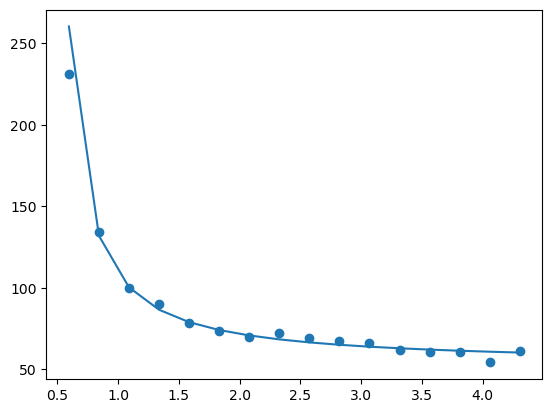

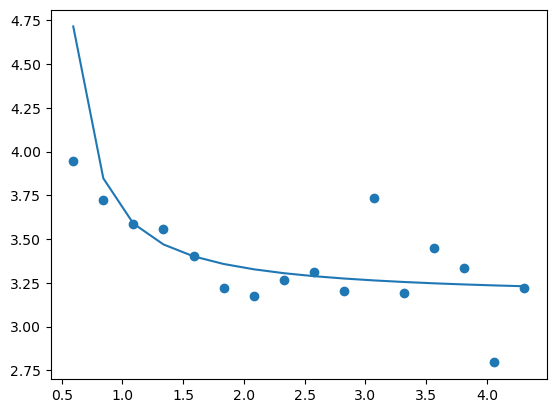

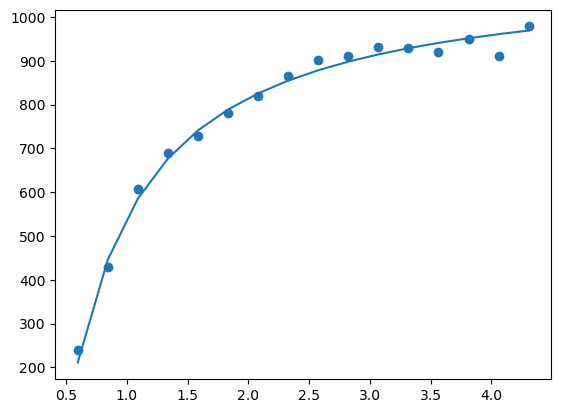

In [27]:
plt.scatter(inv_alpha_range, q_list)
plt.plot(inv_alpha_range, np.array(qs_for_erm_error))
plt.show()

plt.scatter(inv_alpha_range, m_list)
plt.plot(inv_alpha_range, np.array(ms_for_erm_error))
plt.show()

In [28]:
print('Experimental values of m : ')
print(list(m_list))
print('Experimental values of q : ')
print(list(q_list))
print('Experimental values of the Hessian trace : ')
print(list(hessian_list))

[0.5949494949494949, 0.8424242424242424, 1.0898989898989901, 1.3373737373737375, 1.5848484848484852, 1.8323232323232326, 2.0797979797979806, 2.327272727272728, 2.5747474747474755, 2.8222222222222233, 3.06969696969697, 3.3171717171717177, 3.564646464646465, 3.812121212121213, 4.05959595959596, 4.307070707070707]
[3.94526054399227, 3.720798916790793, 3.5862070080933144, 3.5552342601944393, 3.400805546834468, 3.2179312034013656, 3.1743271025028754, 3.26589929934577, 3.31448170500412, 3.2019572820289404, 3.7343156762856586, 3.1894466558395793, 3.4514011311301944, 3.334326305969314, 2.7948528101946377, 3.2227090750161316]
[231.37108602534772, 134.0745996903291, 100.17604585338802, 90.04654027080619, 78.47157354290864, 73.25888877738771, 69.72514115374058, 72.49826480360089, 69.27324989007754, 67.22216481469876, 66.32898897483628, 61.77423513453153, 60.55740197262283, 60.397963436590786, 54.22392988995524, 61.15301402707208]
[238.85769878 429.20319505 607.75049666 689.34416454 728.14636243
 